In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
data = pd.read_csv('data/train_sample.csv',dtype=dtypes,usecols=train_cols)

In [3]:
data.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [4]:
pd.to_datetime(data.click_time).dt.day.value_counts()

8    34035
7    32393
9    28561
6     5011
Name: click_time, dtype: int64

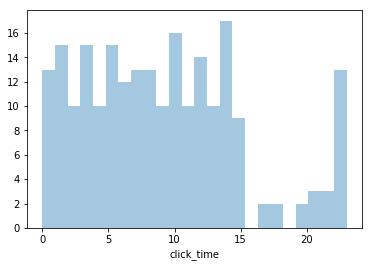

In [5]:
from datetime import datetime
sns.distplot(pd.to_datetime(data[data['is_attributed'] == 1].click_time).dt.hour, bins=24, kde=False)

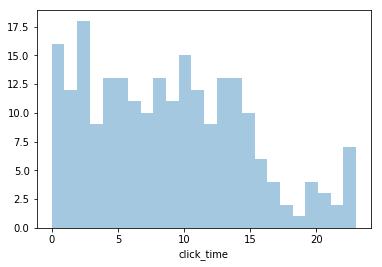

In [6]:
from datetime import datetime
sns.distplot(pd.to_datetime(data[data['is_attributed'] == 0].click_time.sample(227)).dt.hour, bins=24, kde=False)

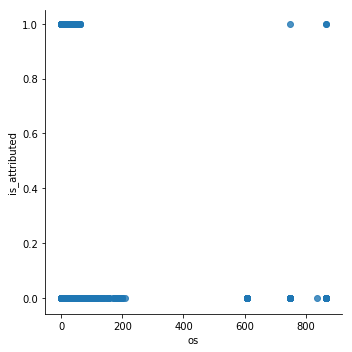

In [7]:
sns.lmplot( x="os", y="is_attributed", data=data, fit_reg=False, legend=False)

In [8]:
data['hour'] = pd.to_datetime(data.click_time).dt.hour.astype('uint8')
data['day'] = pd.to_datetime(data.click_time).dt.day.astype('uint8')

In [9]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

data['in_test_hh'] = (3 - 2*data['hour'].isin(  most_freq_hours_in_test_data ) - 1*data['hour'].isin( least_freq_hours_in_test_data ) ).astype('uint8')
gp = data[['ip', 'day', 'in_test_hh', 'channel']].groupby(by=['ip', 'day', 'in_test_hh'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_day_test_hh'})
data = data.merge(gp, on=['ip','day','in_test_hh'], how='left')
data['nip_day_test_hh'] = data['nip_day_test_hh'].astype('uint32')
del gp

In [10]:
gp = data[['ip', 'os', 'hour', 'channel']].groupby(by=['ip', 'os', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_os'})
data = data.merge(gp, on=['ip','os','hour'], how='left')
data['nip_hh_os'] = data['nip_hh_os'].astype('uint16')
del gp

In [11]:
gp = data[['ip', 'app', 'hour', 'channel']].groupby(by=['ip', 'app',  'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_app'})
data = data.merge(gp, on=['ip','app','hour'], how='left')
data['nip_hh_app'] = data['nip_hh_app'].astype('uint16')
del gp

In [12]:
gp = data[['ip', 'device', 'hour', 'channel']].groupby(by=['ip', 'device', 'hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'nip_hh_dev'})
data = data.merge(gp, on=['ip','device','hour'], how='left')
data['nip_hh_dev'] = data['nip_hh_dev'].astype('uint32')
del gp

In [13]:
zscore = lambda x: (x - x.mean()) / x.std()
data['hour'] = data.groupby('is_attributed')['hour'].transform(zscore)
data['day'] = data.groupby('is_attributed')['day'].transform(zscore)

In [14]:
data.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,in_test_hh,nip_day_test_hh,nip_hh_os,nip_hh_app,nip_hh_dev
0,87540,12,1,13,497,2017-11-07 09:30:38,0,-0.053307,-0.968658,1,3,1,1,1
1,105560,25,1,17,259,2017-11-07 13:40:27,0,0.593896,-0.968658,1,20,1,1,8
2,101424,12,1,19,212,2017-11-07 18:05:24,0,1.402900,-0.968658,3,1,1,1,1
3,94584,13,1,13,477,2017-11-07 04:58:08,0,-0.862310,-0.968658,1,1,1,1,1
4,68413,12,1,1,178,2017-11-09 09:00:09,0,-0.053307,1.280151,1,1,1,1,1


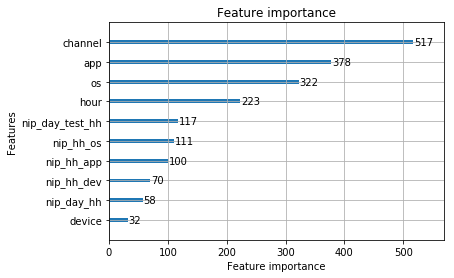

In [15]:
import lightgbm as lgb
bst = lgb.Booster(model_file='model.txt')
lgb.plot_importance(bst, importance_type='split')

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

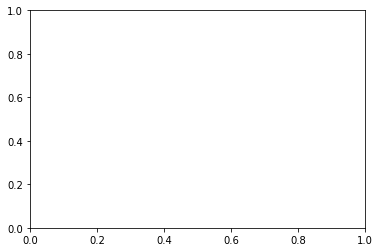

In [16]:
lgb.plot_tree(bst)